### Gruppo 4 Text Analytics 2022/23
- Simona Sette
- Giulio Canapa
- Sara Quattrone
- Diego Borsetto

# BERT for classification

The Bert for Sequence classifier was implemented in order to evaluate whether a transformers language model could return  better results than the previous classifiers, proving to be suitable for the task objective.

## Import

In [3]:
import pandas as pd
import csv
import os.path
import numpy as np
import seaborn as sns
sns.set()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from distutils.version import LooseVersion as LV
from sklearn.model_selection import train_test_split
import io
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.13.1+cu116 Device: cuda [Tesla T4]


In [5]:
df = pd.read_csv("/content/Multiclass_problem_7Classes.csv" ,sep=',', header=0)

## Data preparation

In [6]:
#dropping all the columns not interesting for the classification
df.drop(['Article', 'Paragraph','ID'], axis=1, inplace=True)
df

,Technique,Text
0,Doubt,Geneva - The World Health Organisation chief o...
1,Repetition,"But Tedros voiced alarm that ""plague in Madaga..."
2,Appeal_to_Fear-Prejudice,He also pointed to the presence of the pneumon...
3,Appeal_to_Fear-Prejudice,He praised the rapid response from WHO and Mad...
4,Appeal_to_Fear-Prejudice,That means that Madagascar could be affected m...
...,...,...
1873,Doubt,The story was completely false and the Guardia...
1874,Loaded_Language,Andy Warhol was only half-right. In the future...
1875,Exaggeration-Minimisation,Saturday Night Live writer and comedian Nimesh...
1876,Name_Calling-Labeling,That's what Columbia snowflakes thought was of...


Generation of dataframes containing persuasion techniques (y) and paragraph textual content (X).

In [7]:
y=df['Technique']
X=df.loc[:, df.columns != 'Technique']

Performing Random Undersampling in order to reduce the majority class (Loaded_Language with 806 records).

In [8]:
undersample = RandomUnderSampler(sampling_strategy={'Name_Calling-Labeling': 318, 'Repetition': 218, 'Doubt': 210, 'Appeal_to_Fear-Prejudice': 122, 
                                                    'Exaggeration-Minimisation': 102, 'Flag_Waving': 102, 'Loaded_Language': 350})
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [9]:
X_under

,Text
0,"“Bishops are quick learners,” he wrote in his ..."
1,“I have done what I believe God wanted me to d...
2,Ebola is one of the world's most notorious dis...
3,"Paul Hunter, a professor of health protection ..."
4,And whoso falleth not down and worshippeth sha...
...,...
1417,The document makes it inarguable that the fede...
1418,"When the Russians retaliated, the Trump admini..."
1419,"Trumpism is not a detour, after which we can a..."
1420,Other theories behind the health issues in Cub...


Post undersampling class frequency control:

In [10]:
print(Counter(y_under))

Counter({'Loaded_Language': 350, 'Name_Calling-Labeling': 318, 'Repetition': 218, 'Doubt': 210, 'Appeal_to_Fear-Prejudice': 122, 'Exaggeration-Minimisation': 102, 'Flag_Waving': 102})


In [11]:
#set splitting in train set and test set (70% and 30%)
X_train, X_test, y_train, y_test = train_test_split(X_under,y_under,stratify=y_under,test_size=0.3, random_state=100)

We save both the paragraphs textual content of the train and test and their lables in lists.

In [12]:
X_train_lista = list()
for x in X_train['Text']:
    X_train_lista.append(str(x))
    
y_train_lista = list()
for i in y_train:
    y_train_lista.append(str(i))

X_test_lista = list()
for x in X_test['Text']:
    X_test_lista.append(str(x))
    
y_test_lista = list()
for i in y_test:
    y_test_lista.append(str(i))

Example of access to a  train set paragraph and its label in position 10:

In [13]:
X_train_lista[10]

'Orban said on Sunday that Europe faces a critical fissure between nation states of the East and the West, which he called an "immigrant zone, a mixed population world that heads in a direction different from ours".'

In [14]:
y_train_lista[10]

'Flag_Waving'

We carry out a mapping of the labels and create an array containing the labels for each paragraph of the train and test set.

In [15]:
label_map = {label:idx for idx,label in enumerate(sorted(set(y_train)))}
print(label_map)

y_train_vect = np.asarray([label_map[label] for label in y_train_lista])
y_test_vect = np.asarray([label_map[label] for label in y_test_lista])

#y_train_vect,y_test_vect

{'Appeal_to_Fear-Prejudice': 0, 'Doubt': 1, 'Exaggeration-Minimisation': 2, 'Flag_Waving': 3, 'Loaded_Language': 4, 'Name_Calling-Labeling': 5, 'Repetition': 6}


Begin formatting paragraphs as necessary to be interpreted by BERT:

In [16]:
# adding [CLS] token to the beginning of each textual paragraph
sentences_train = ["[CLS] " + s for s in X_train_lista]
sentences_test = ["[CLS] " + s for s in X_test_lista]
labels_train = y_train_vect
labels_test  = y_test_vect

In [17]:
#loading the BERT model and classifier
BERTMODEL = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(BERTMODEL,
                                          do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [18]:
#apply bert tokenizer to the previous textual paragraphs where the token was added
tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 427/427 [00:00<00:00, 842.56it/s]


In [19]:
# truncate the dimensions of the individual paragraphs so that they respect the limits of the bert-base-uncased model
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

In [20]:
# convert the tokens present in the individual paragraphs into ids and perform a pad by adding zeros so that the length of the individual paragraphs is homogeneous
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

In [ ]:
# create attention masks for both train and test set, with 1 for each real token in the sequences and 0 for the padding
amasks_train, amasks_test = [], []

for seq in ids_train:
    seq_mask = [float(i>0) for i in seq]
    amasks_train.append(seq_mask)

for seq in ids_test:
    seq_mask = [float(i>0) for i in seq]
    amasks_test.append(seq_mask)

Splitting the entire dataset into training and validation datasets using 90/10 ratio and employ random_state to make sure that all input data are correctly ordered. 

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

Converting each input data format from list to torch tensor (both for validation, train and test set).

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

### Hyperparameters choice

Different possible value for each parameter were considered and tried in different combination:
- batch sizes: 8, 16, 32, 64;
- learning rates: 3e-4, 5e-5, 3e-5;
- weight decay: 0.1, 0.01, 0.001;
- eps_set: 1e-7, 1e-8;
- epochs: 4, 5, 6, 7, 10;

The best combination in terms of performances resulted to be the following one:

In [ ]:
BATCH_SIZE = 8
WEIGHT_DECAY1 = 0.01
LR = 5e-5
EPOCHS = 5
eps_set = 1e-8
no_decay = ['bias', 'LayerNorm.weight','gamma', 'beta']

We combine relevant tensors into a tensor dataset for each sub-data set and load tensor datasets into dataloaders.

In [ ]:
print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels.type(torch.LongTensor))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels.type(torch.LongTensor))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels.type(torch.LongTensor))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 895 documents
Validation: 100 documents
Test: 427 documents


We use a pre-trained model for sequence classification and set the model to use GPU in order to parallelize calculation.

In [ ]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Pretrained BERT model "bert-base-uncased" loaded


After separating weight parameters from bias, gamma, LayerNorm.weight and beta parameters we filter one group without these values and another with them. 

We set up optimizer and scheduler needed for learning with default settings.

In [ ]:
WARMUP_STEPS =int(0.2*len(train_dataloader))
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY1},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=eps_set)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

In [ ]:
#definition of the trainer and evaluer 

def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))



def evaluate(loader):
    
    model.eval()
    # Tracking variables
    n_correct, n_all = 0, 0

    predicted_labels = list()
    true_labels = list()
    # Predict 
    for batch in loader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None,
                          attention_mask=b_input_mask)
            logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        # Store predictions and true labels
        labels = b_labels.to('cpu').numpy()
        n_correct += np.sum(predictions == labels)

        true_labels.extend(labels)
        predicted_labels.extend(predictions)
        n_all += len(labels)

    print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
    print('Classification report:')
    print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
    print('Confusion matrix:')
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

Training the model on the training set and evaluing it trough the validation set in order to choose the best parameter setting.

In [ ]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)   


Train Epoch: 1 [0/895 (0%)]	Loss: 2.245162

Validation set:
Accuracy: [37/100] 0.3700
Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       1.00      0.17      0.29         6
                    Doubt       0.30      0.43      0.35        14
Exaggeration-Minimisation       0.00      0.00      0.00        11
              Flag_Waving       0.00      0.00      0.00         6
          Loaded_Language       0.40      0.64      0.49        28
    Name_Calling-Labeling       0.35      0.50      0.41        24
               Repetition       0.00      0.00      0.00        11

                 accuracy                           0.37       100
                macro avg       0.29      0.25      0.22       100
             weighted avg       0.30      0.37      0.30       100

Confusion matrix:
[[ 1  0  0  0  2  3  0]
 [ 0  6  0  0  6  2  0]
 [ 0  3  0  0  4  4  0]
 [ 0  1  0  0  2  3  0]
 [ 0  3  0  0 18  7  0]
 [ 0  5  0  

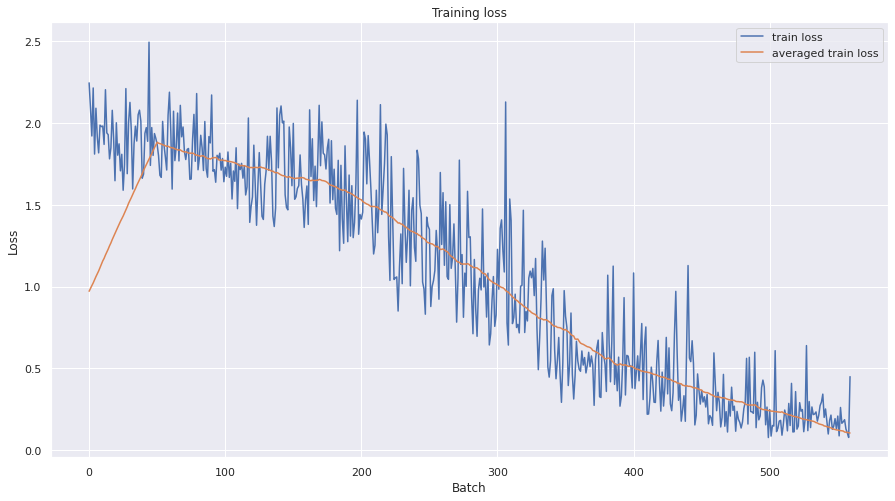

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='train loss')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,  label='averaged train loss')
plt.legend(loc='best')
plt.show()

Plotting the training loss trough the increasing batch number considered in order to evaluate how much the various passes impact on the model learning.

Finally, after implementing the shown and best tried parameter setting, the model was finally executed on the test set, resulting in the following performance:

In [ ]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [220/427] 0.5152
Classification report:
                           precision    recall  f1-score   support

 Appeal_to_Fear-Prejudice       0.35      0.38      0.36        37
                    Doubt       0.67      0.59      0.63        63
Exaggeration-Minimisation       0.41      0.23      0.29        31
              Flag_Waving       0.61      0.74      0.67        31
          Loaded_Language       0.48      0.61      0.54       105
    Name_Calling-Labeling       0.62      0.43      0.51        95
               Repetition       0.43      0.52      0.47        65

                 accuracy                           0.52       427
                macro avg       0.51      0.50      0.50       427
             weighted avg       0.53      0.52      0.51       427

Confusion matrix:
[[14  4  1  2  9  0  7]
 [ 4 37  1  0 11  2  8]
 [ 2  3  7  4  7  5  3]
 [ 0  1  1 23  1  0  5]
 [ 7  4  3  3 64 12 12]
 [ 9  5  1  2 27 41 10]
 [ 4  1  3  4 13  6 34]]
